### Purpose:
 - Download retrospective hourly analysis & assimilation NWM files from the Google Cloud archive
 - Obtain and plot the discharge time series of a stream of interest
 - Run the cells in order to import libraries, select parameters, define functions, download files, and plot a discharge series
    
### Inputs:
 - (1) begin date for data retrieval
 - (2) end date for data retrieval (inclusive)
 - (3) desired product (channel routing or forcing)
 - (4) directory for downloaded files

In [1]:
# import python libraries

import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sys
import xarray as xr

from matplotlib.dates import DateFormatter
from time import sleep

In [6]:
# select input parameters

begindate = '20190917' # data is avail. beginning 20180917
enddate = '20190927'
# enddate = '20190930' # inclusive
product = 'channel_rt' # 'channel_rt' or 'forcing'
destfolder_name = 'test2' # directory will be created in current working directory if it does not already exist

In [7]:
# define functions

def get_netcdf(filetype,begin_date,end_date,output_folder_name):
    
    output_folder = os.path.join(os.getcwd(),output_folder_name)
    
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    if filetype =='channel_rt':
        prodstr = ''
    elif filetype == 'forcing':
        prodstr = 'forcing_'
    else:
        print("Product error. Choose 'channel_rt' or 'forcing'.")
        sys.exit()
    
        
    
    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1,t2)
    
    for i in range(len(dates)):
        date = dates[i]
        save_dir = date.strftime('%Y%m%d')
        
        if not os.path.exists(output_folder+'/'+save_dir):
            os.mkdir(output_folder+'/'+save_dir)
            
        for hr in range(24):
            
            # url = f'https://storage.googleapis.com/national-water-model/' \
            #       f'nwm.{date.strftime("%Y%m%d")}/{prodstr}analysis_assim/' \
            #       f'nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.tm00.conus.nc'
            url = f'https://storage.googleapis.com/national-water-model/' \
                  f'nwm.{date.strftime("%Y%m%d")}/{prodstr}short_range/' \
                  f'nwm.t{str(hr).zfill(2)}z.short_range.{filetype}.f001.conus.nc'
                #   https://storage.googleapis.com/national-water-model/nwm.20200404/analysis_assim/nwm.t00z.analysis_assim.channel_rt.tm00.conus.nc
                #   https://storage.googleapis.com/national-water-model/nwm.20200404/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
            # url = 'https://storage.googleapis.com/national-water-model/nwm/prod/nwm.20190917/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'
            filename = os.path.basename(url)
            write_file = os.path.join(output_folder, save_dir, filename)

            for attempt in range(30):
                try:
                    r = requests.get(url)
                    with open(write_file, 'wb') as f:
                        f.write(r.content)
                    break
                except Exception as ex:
                    if attempt != max_attempts - 1:
                        sleep(0.5)  # Give NOAA time to wake up
                    else:
                        m = 'Could not download file.\n' + str(ex)
                        raise Exception(m)
                        
        print(f'{save_dir} done')
       
        
def get_series(comid, begin_date, end_date, datafolder_name, filetype):
    
    data_folder = os.path.join(os.getcwd(), datafolder_name)
    
    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1,t2)
    
    df = pd.DataFrame()
    
    for i in range(len(dates)):
        date = dates[i]
        date_dir = date.strftime('%Y%m%d')
            
        for hr in range(24):
            # filename = f'nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.f001.conus.nc'
            filename = f'nwm.t{str(hr).zfill(2)}z.short_range.{filetype}.f001.conus.nc'
            # nwm.t00z.short_range.channel_rt.f001.conus.nc
            nc_file = os.path.join(data_folder, date_dir, filename)
            data = xr.open_dataset(nc_file)
            Q = float(data.sel(feature_id=comid).streamflow.values)
            timestamp = pd.to_datetime(f'{date_dir} {hr}:00')
            df.loc[timestamp,'Q'] = Q
    
    return df
    


In [8]:
# download files

get_netcdf(product,begindate,enddate,destfolder_name)

20190917 done
20190918 done
20190919 done
20190920 done
20190921 done
20190922 done
20190923 done
20190924 done
20190925 done
20190926 done
20190927 done


In [46]:
# extract a discharge time series for an individual stream from the downloaded files
# this example shows a reach of the Sabine River in Southeast Texas during TS Imelda
# compare: https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&format=gif_default&site_no=08030500&period=&begin_date=2019-09-15&end_date=2019-09-30

comid = 1479611
# 1114345 # Neches River Saltwater Barrier 8331880 # Sabine river near USGS gage 08030500
sabine_timeseries_df = get_series(comid, begindate, enddate, destfolder_name, product)
# print (sabine_timeseries_df)
sabine_timeseries_df.to_csv('NWM_discharge.csv')
nwm_discharge = pd.read_csv('NWM_discharge.csv')
nwm_discharge = nwm_discharge.rename(columns={" ":"Time", "Q":"Discharge"})
nwm_discharge


,Unnamed: 0,Discharge
0,2019-09-17 00:00:00,0.26
1,2019-09-17 01:00:00,0.25
2,2019-09-17 02:00:00,0.25
3,2019-09-17 03:00:00,0.25
4,2019-09-17 04:00:00,0.25
...,...,...
259,2019-09-27 19:00:00,5.77
260,2019-09-27 20:00:00,5.71
261,2019-09-27 21:00:00,5.66
262,2019-09-27 22:00:00,5.60


<Figure size 432x288 with 0 Axes>

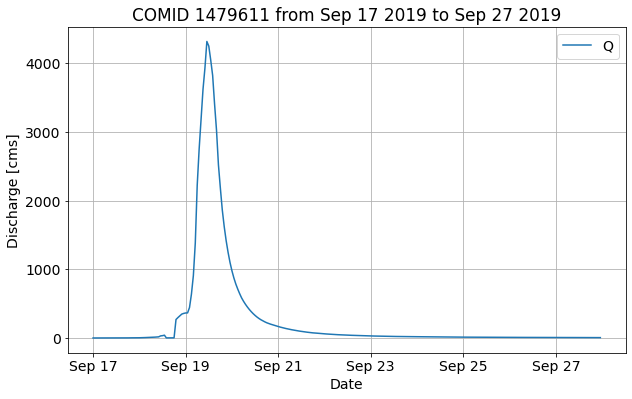

In [23]:
# plot the discharge time series
plt.figure(facecolor='white')
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sabine_timeseries_df, color='tab:blue', label='Q')
ax.set(xlabel='Date',
       ylabel='Discharge [cms]',
       title=f'COMID {comid} from ' \
       f'{pd.to_datetime(begindate).strftime("%b %d %Y")} to ' \
       f'{pd.to_datetime(enddate).strftime("%b %d %Y")}')
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.grid(True)
plt.savefig('Discharge_graph.jpg')

In [24]:
#Combining with the USGS / DD6 gages Get the USGS file
import json
import pandas as pd

file = open("C:/Users/st35889/Coding/datasphere/data2/JAIT2.json")
obj = json.load(file)

data = obj['locations'][0]['timeseries'][0]['data']
cols = obj['locations'][0]['timeseries'][0]['columns'].split(',')

df = pd.DataFrame(data=data,columns=cols)
# print (obj)
print(df)

                    timestamp  value quality
0    2019-09-17T00:23:42.000Z   2.82    None
1    2019-09-17T08:53:43.000Z   2.92    None
2    2019-09-17T09:08:44.000Z   2.87    None
3    2019-09-17T09:23:43.000Z   2.97    None
4    2019-09-17T12:38:44.000Z   3.12    None
..                        ...    ...     ...
224  2019-09-26T21:09:23.000Z  12.61    None
225  2019-09-26T21:24:23.000Z  12.51    None
226  2019-09-26T21:39:23.000Z  12.61    None
227  2019-09-26T22:09:23.000Z  12.44    None
228  2019-09-26T23:39:23.000Z  12.19    None

[229 rows x 3 columns]


In [25]:
#Import file for Rating Curve
import pickle
rating_curves = pickle.load( open( "D:/Sujana/Project/rating_curves_dict.p", "rb" ) )

In [26]:
# Get relevant rating curve for specific stream
rc120402 = rating_curves['120402']

In [27]:
# Get the rating curve for the specific stream in this huc6.
rating_curve_gage = rc120402[rc120402['CatchId']==1479611]

In [28]:
#View rating curve data
rating_curve_gage

,CatchId,Stage,Number of Cells,SurfaceArea (m2),BedArea (m2),Volume (m3),SLOPE,LENGTHKM,AREASQKM,Roughness,TopWidth (m),WettedPerimeter (m),WetArea (m2),HydraulicRadius (m),Discharge (m3s-1)
107319,1479611,0.0000,8910,8.180340e+05,8.180341e+05,-1.948000e-03,0.00001,9.39,25.8912,0.05,87.117573,87.117582,-2.074547e-07,-2.381319e-09,NaN
107320,1479611,0.3048,42150,3.870203e+06,3.870234e+06,6.328104e+05,0.00001,9.39,25.8912,0.05,412.162221,412.165517,6.739194e+01,1.635070e-01,1.274468
107321,1479611,0.6096,60932,5.594748e+06,5.594849e+06,2.077490e+06,0.00001,9.39,25.8912,0.05,595.819857,595.830558,2.212449e+02,3.713219e-01,7.228868
107322,1479611,0.9144,98043,9.001942e+06,9.002141e+06,4.386397e+06,0.00001,9.39,25.8912,0.05,958.673240,958.694470,4.671349e+02,4.872615e-01,18.294214
107323,1479611,1.2192,118903,1.091706e+07,1.091736e+07,7.452811e+06,0.00001,9.39,25.8912,0.05,1162.626426,1162.658284,7.936966e+02,6.826569e-01,38.918209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107397,1479611,23.7744,281966,2.588750e+07,2.588829e+07,5.757903e+08,0.00001,9.39,25.8912,0.05,2756.922611,2757.006775,6.131952e+04,2.224134e+01,30671.573284
107398,1479611,24.0792,281966,2.588750e+07,2.588829e+07,5.836808e+08,0.00001,9.39,25.8912,0.05,2756.922611,2757.006775,6.215983e+04,2.254613e+01,31375.296518
107399,1479611,24.3840,281966,2.588750e+07,2.588829e+07,5.915713e+08,0.00001,9.39,25.8912,0.05,2756.922611,2757.006775,6.300014e+04,2.285092e+01,32085.390753
107400,1479611,24.6888,281966,2.588750e+07,2.588829e+07,5.994619e+08,0.00001,9.39,25.8912,0.05,2756.922611,2757.006775,6.384045e+04,2.315571e+01,32801.827534


In [29]:
#Interpolation to convert NWM discharge to stage
interpolated_stage = list()
from scipy.interpolate import interp1d
discharge_list = list(rating_curve_gage['Discharge (m3s-1)'])
stage_list = list(rating_curve_gage['Stage'])
y_interp = interp1d(discharge_list, stage_list, fill_value='extrapolate')
interpolated_stage.append(float(y_interp(discharge)))
# y_interp = interp1d(rating_curve_gage['Discharge (m3s-1)'], rating_curve_gage['Stage'], fill_value='extrapolate')

TypeError: only size-1 arrays can be converted to Python scalars

In [17]:
y_interp